In [1]:
#Plot 5 - Fraction of 

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [3]:
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [4]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [5]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number netween 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue
    

In [6]:
########## CONUS ############
#CONUS lat-lon
ctop    = 50.0 # north lat
cleft   = (360-124.7844079)%360 # west long
cright  = (360-66.9513812)%360# east long
cbottom =  24.7433195 # south lat
################################
#Europe lat-lon
eutop     = 60.0
eubottom  = 35.0
euleft    = (360-10.0)%360
euright   = 50

################################
cesm2          = '/global/scratch/users/harsha/LENS/cesm2/'
cesm2_path     = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
icefrac_path   = cesm2 + 'seaicefrac/1850_2100/'
snowfrac_path  = cesm2 + 'snowfrac/1850_2100/'
cvals          = cesm2 + 'cvals/'
cvals1         = cesm2 + '/tmax_mem'
##############################
print(cleft,cright)
print(icefrac_path)

235.21559209999998 293.0486188
/global/scratch/users/harsha/LENS/cesm2/seaicefrac/1850_2100/


In [7]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(4)

In [8]:
cluster

In [9]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [10]:
def to_monthly(ds):
    year  = ds.time.dt.year
    month = ds.time.dt.month

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "month")).unstack("time")  

In [11]:
def stacker(x):
    #Assumes that x has dimensions year and member
    x = x.stack(ym=('year','member'),create_index=False)
    return x
def stacker2(x):
    #Assumes that x has dimensions year and member
    x = x.stack(mtime=('year','member'),create_index=False)
    return x

In [12]:
def stack_roll(ds,roll_len,stride_len):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds)
    print(ds_stack)
    ds_roll    = ds_stack.rolling(ym=roll_len, center=True).construct('index', stride=stride_len)
    
    return ds_roll   

In [13]:
def global_annual_rmse(arr_err, dim):
      #Compute spatially weighted global mean of square error
      # and then compute annual rmse #g = global, a= annual
        arr_err_sq            = arr_err**2
        weights               = np.cos(np.deg2rad(arr_err_sq.lat))
        weights.name          = "weights"
        arr_serror_weighted   = arr_err_sq.weighted(weights)
        arr_serror_gmean      = arr_serror_weighted.mean({'lat','lon'},skipna=True)
        ####
        arr_gamse             = arr_serror_gmean.mean(dim)
        arr_garmse            = np.sqrt(arr_gamse)
        
        return arr_garmse

In [14]:
cluster

In [15]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
#doy      = 211 # day_of_year
#date     = 'Jul30'

In [16]:
#Get all the ensemble member labels in a list and also get a list of dates.
directory   = cesm2 + 'seaicefrac/1850_2100/'
files       = glob.glob(directory+"b.e21.BHIST*.nc") + glob.glob(directory+"b.e21.BSSP370*.nc")
datelen     = 16
emembers    = [f.replace(directory,"").replace("b.e21.BHIST","").replace("b.e21.BSSP370","")\
              .replace("cam.h0.ICEFRAC.","")\
              .replace("f09_g17.LE2-","").replace("cmip6.","").replace("smbb.","") \
              for f in files] 
#print(emembers)
dates       = [f[-datelen:].replace('.nc',"") for f in emembers]
emembers    = [f.replace(f[-datelen:],"") for f in emembers]
emembers    = list(set(emembers)) #remove repetitions
emembers    = sorted(emembers) #sort in ascending order
dates       = list(set(dates)) #remove repetitions
dates       = sorted(dates)

In [17]:
#Get all the ensemble member labels in a list and also get a list of dates.
directory1  = cesm2 + 'snowfrac/1850_2100/'
files1      = glob.glob(directory1+"b.e21.BHIST*.nc") + glob.glob(directory1+"b.e21.BSSP370*.nc")
datelen1    = 16
emembers1   = [f.replace(directory1,"").replace("b.e21.BHIST","").replace("b.e21.BSSP370","")\
              .replace("clm2.h0.FSNO_ICE.","")\
              .replace("f09_g17.LE2-","").replace("cmip6.","").replace("smbb.","") \
              for f in files1] 
#print(emembers)
dates1       = [f[-datelen1:].replace('.nc',"") for f in emembers1]
emembers1    = [f.replace(f[-datelen1:],"") for f in emembers1]
emembers1    = list(set(emembers1)) #remove repetitions
emembers1    = sorted(emembers1) #sort in ascending order
dates1       = list(set(dates1)) #remove repetitions
dates1       = sorted(dates1)

In [18]:
print(dates1,emembers1)

['185001-185912', '209501-210012'] ['1001.001.', '1021.002.', '1041.003.', '1061.004.', '1081.005.', '1101.006.', '1121.007.', '1141.008.', '1161.009.', '1181.010.', '1231.001.', '1231.002.', '1231.003.', '1231.004.', '1231.005.', '1231.006.', '1231.007.', '1231.008.', '1231.009.', '1231.010.', '1231.011.', '1231.012.', '1231.013.', '1231.014.', '1231.015.', '1231.016.', '1231.017.', '1231.018.', '1231.019.', '1231.020.', '1251.001.', '1251.002.', '1251.003.', '1251.004.', '1251.005.', '1251.006.', '1251.007.', '1251.008.', '1251.009.', '1251.010.', '1251.011.', '1251.012.', '1251.013.', '1251.014.', '1251.015.', '1251.016.', '1251.017.', '1251.018.', '1251.019.', '1251.020.', '1281.001.', '1281.002.', '1281.003.', '1281.004.', '1281.005.', '1281.006.', '1281.007.', '1281.008.', '1281.009.', '1281.010.', '1281.011.', '1281.012.', '1281.013.', '1281.014.', '1281.015.', '1281.016.', '1281.017.', '1281.018.', '1281.019.', '1281.020.', '1301.001.', '1301.002.', '1301.003.', '1301.004.', '1

In [19]:
#Create a file1, with file paths sorted by emember for each time period. sice = sea-ice
file_sice = []
file_snow = []
for j in range(2):
    file0  = sorted(glob.glob(directory+'*'+dates[j]+'.nc'))
    file1  = sorted(glob.glob(directory1+'*'+dates[j]+'.nc'))
    file_sice.append(file0)
    file_snow.append(file1)
#file_sice is now a list of lists.

In [20]:
len(file_sice[0])

100

In [21]:
#Create zarr paths
icefrac_zarrpath    = cesm2 + 'seaicefrac/emem/'
snowfrac_zarrpath   = cesm2 + 'snowfrac/emem/'
# filename  = 'b.e21.BHIST.'
# path      = scratchf+filename
# emembs    = list(range(100))
# emembs    = [str(ememb).zfill(3) for ememb in emembs]
sice_paths     = []
snow_paths     = []

for jj in range(2):
    path0  = icefrac_zarrpath +'icefrac.'+ dates[jj]+'.zarr'
    path1  = snowfrac_zarrpath +'fsno_ice.'+ dates[jj]+'.zarr'
    sice_paths.append(path0)
    snow_paths.append(path1)

In [22]:
print(sice_paths[0])

/global/scratch/users/harsha/LENS/cesm2/seaicefrac/emem/icefrac.185001-185912.zarr


In [23]:
# %%time
# #Write zarr files where each zarr has data for a 10-year period and all ensembles
# for kk in range(2):
#     ds = xr.open_mfdataset(file_sice[kk],decode_times=True,decode_timedelta='True',combine='nested',concat_dim='member')
#     ds = ds.ICEFRAC
#     ds = ds.assign_coords(member=('member',np.arange(100)))
#     #print(ds)
#     ds = ds.to_dataset()
#     print(sice_paths[kk])
#     ds.to_zarr(sice_paths[kk],mode='w')
#     ds.close()
#     print('Closed directory')

In [25]:
# %%time
# #Write zarr files where each zarr has data for a 10-year period and all ensembles
# for kk in range(2):
#     ds = xr.open_mfdataset(file_snow[kk],decode_times=True,decode_timedelta='True',combine='nested',concat_dim='member')
#     ds = ds.FSNO_ICE
#     ds = ds.assign_coords(member=('member',np.arange(90)))
#     #print(ds)
#     ds = ds.to_dataset()
#     print(snow_paths[kk])
#     ds.to_zarr(snow_paths[kk],mode='w')
#     ds.close()
#     print('Closed directory')

/global/scratch/users/harsha/LENS/cesm2/snowfrac/emem/fsno_ice.185001-185912.zarr
Closed directory
/global/scratch/users/harsha/LENS/cesm2/snowfrac/emem/fsno_ice.209501-210012.zarr
Closed directory
CPU times: user 14 s, sys: 1.23 s, total: 15.3 s
Wall time: 26.5 s


In [29]:
%%time 
sicefrac  = xr.open_mfdataset(sice_paths[:],engine='zarr')
sicefrac  = sicefrac.ICEFRAC
sicefrac

CPU times: user 60.2 ms, sys: 15.3 ms, total: 75.5 ms
Wall time: 500 ms


,Array,Chunk
Bytes,3.96 GiB,25.31 MiB
Shape,"(100, 192, 192, 288)","(1, 120, 192, 288)"
Count,402 Tasks,200 Chunks
Type,float32,numpy.ndarray


In [27]:
%%time 
snowfrac  = xr.open_mfdataset(snow_paths[:],engine='zarr')
snowfrac  = snowfrac.FSNO_ICE
snowfrac

CPU times: user 27.6 ms, sys: 3.89 ms, total: 31.5 ms
Wall time: 33.3 ms


,Array,Chunk
Bytes,3.56 GiB,25.31 MiB
Shape,"(90, 192, 192, 288)","(1, 120, 192, 288)"
Count,362 Tasks,180 Chunks
Type,float32,numpy.ndarray


In [31]:
sicefrac_m = to_monthly(sicefrac)
snowfrac_m = to_monthly(snowfrac)
snowfrac_m

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

,Array,Chunk
Bytes,4.00 GiB,27.84 MiB
Shape,"(90, 192, 288, 18, 12)","(1, 192, 288, 11, 12)"
Count,2350 Tasks,180 Chunks
Type,float32,numpy.ndarray


In [35]:
sicefrac_djf     = sicefrac_m.sel(month=[12,1,2])
sicefrac_djf_ano = sicefrac_djf.sel(year=2100) - sicefrac_djf.sel(year=1850)
#
sicefrac_mam     = sicefrac_m.sel(month=[3,4,5])
sicefrac_mam_ano = sicefrac_mam.sel(year=2100) - sicefrac_mam.sel(year=1850)
#
sicefrac_jja     = sicefrac_m.sel(month=[6,7,8])
sicefrac_jja_ano = sicefrac_jja.sel(year=2100) - sicefrac_jja.sel(year=1850)
#
sicefrac_son     = sicefrac_m.sel(month=[9,10,11])
sicefrac_son_ano = sicefrac_son.sel(year=2100) - sicefrac_son.sel(year=1850)
## July anomaly #####
snowfrac_july_emean    = snowfrac_m.sel(month=[7]).mean('member')
sicefrac_july_emean    = sicefrac_m.sel(month=[7]).mean('member')
#
snowfrac_july_mano      = snowfrac_july_emean.sel(year=2100) - snowfrac_july_emean.sel(year=1850)
sicefrac_july_mano      = sicefrac_july_emean.sel(year=2100) - sicefrac_july_emean.sel(year=1850)

In [33]:
snowfrac_july_emean

<xarray.DataArray 'FSNO_ICE' (lat: 192, lon: 288, year: 18, month: 1)>
dask.array<mean_agg-aggregate, shape=(192, 288, 18, 1), dtype=float32, chunksize=(192, 288, 11, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100 2101
  * month    (month) int64 7
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

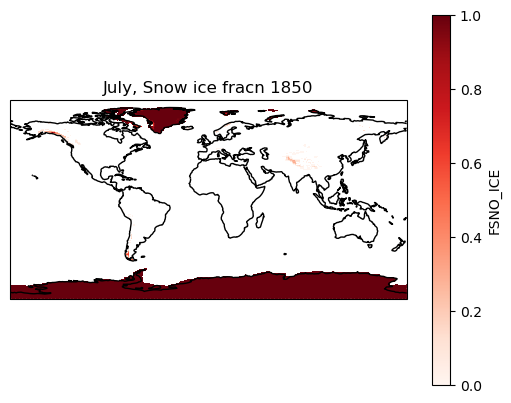

CPU times: user 1.55 s, sys: 33.1 ms, total: 1.59 s
Wall time: 2.65 s


In [59]:
%%time
ax = plt.axes(projection=cart.crs.PlateCarree())
snowfrac_july_emean.sel(year=1850).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap='Reds')
#sicefrac_july_mano.plot(ax=ax,transform=cart.crs.PlateCarree(),cmap='RdBu')
ax.coastlines(color="black")
plt.title('July, Snow ice fracn 1850')
plt.show()

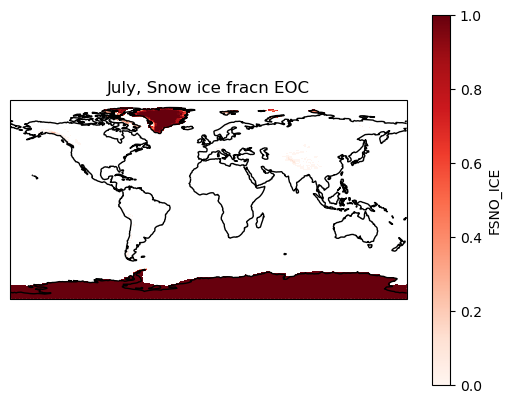

CPU times: user 2.05 s, sys: 77.5 ms, total: 2.13 s
Wall time: 3.25 s


In [60]:
%%time
ax = plt.axes(projection=cart.crs.PlateCarree())
snowfrac_july_emean.sel(year=2100).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap='Reds')
#sicefrac_july_mano.plot(ax=ax,transform=cart.crs.PlateCarree(),cmap='RdBu')
ax.coastlines(color="black")
plt.title('July, Snow ice fracn EOC')
plt.show()

In [49]:
seaice_july_ano  = sicefrac_july_ano.to_dataset(name='seaicefrac')
snowice_july_ano = snowfrac_july_ano.to_dataset(name='snowicefrac')

# Merge Datasets
total_icefrac = xr.merge([seaice_july_ano, snowice_july_ano])

# Create a new DataArray for total ice fraction by adding the two fractions
# You might want to adjust this if 'seaicefrac' and 'snowicefrac' don't directly add up in your case
total_icefrac['toticefrac_july_ano'] = total_icefrac['seaicefrac'].fillna(0) + total_icefrac['snowicefrac'].fillna(0)
total_icefrac

<xarray.Dataset>
Dimensions:              (month: 1, lat: 382, lon: 288)
Coordinates:
  * month                (month) int64 7
  * lat                  (lat) float64 -90.0 -89.06 -89.06 ... 89.06 89.06 90.0
  * lon                  (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
Data variables:
    seaicefrac           (lat, lon, month) float32 dask.array<chunksize=(382, 288, 1), meta=np.ndarray>
    snowicefrac          (lat, lon, month) float32 dask.array<chunksize=(382, 288, 1), meta=np.ndarray>
    toticefrac_july_ano  (lat, lon, month) float32 dask.array<chunksize=(382, 288, 1), meta=np.ndarray>

In [52]:
snowfrac_july_mano.values

array([[[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       ...,

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]]], dtype=float32)

In [50]:
total_icefrac_july_ano = total_icefrac.toticefrac_july_ano
total_icefrac_july_ano

<xarray.DataArray 'toticefrac_july_ano' (lat: 382, lon: 288, month: 1)>
dask.array<add, shape=(382, 288, 1), dtype=float32, chunksize=(382, 288, 1), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 7
  * lat      (lat) float64 -90.0 -89.06 -89.06 -88.12 ... 88.12 89.06 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

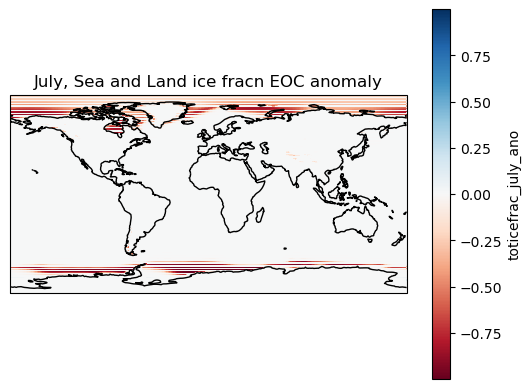

CPU times: user 5.65 s, sys: 244 ms, total: 5.89 s
Wall time: 8.44 s


In [51]:
%%time
ax = plt.axes(projection=cart.crs.PlateCarree())
total_icefrac_july_ano.plot(ax=ax,transform=cart.crs.PlateCarree(),cmap='RdBu')
ax.coastlines(color="black")
plt.title('July, Sea and Land ice fracn EOC anomaly')
plt.show()

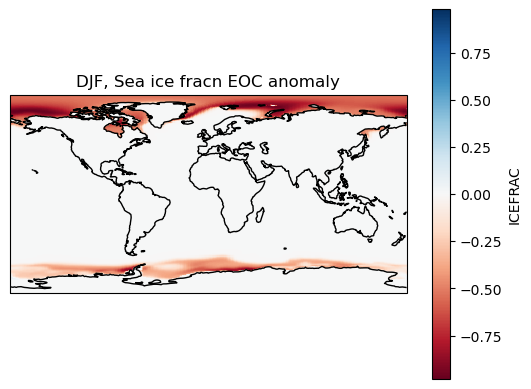

CPU times: user 3.97 s, sys: 136 ms, total: 4.11 s
Wall time: 5.41 s


In [43]:
%%time
ax = plt.axes(projection=cart.crs.PlateCarree())
sicefrac_djf_ano.mean({'month','member'}).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap='RdBu')
ax.coastlines(color="black")
plt.title('DJF, Sea ice fracn EOC anomaly')
plt.show()

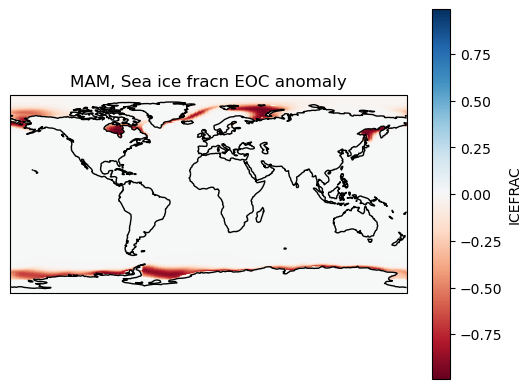

CPU times: user 3.63 s, sys: 106 ms, total: 3.74 s
Wall time: 4.94 s


In [45]:
%%time
ax = plt.axes(projection=cart.crs.PlateCarree())
sicefrac_mam_ano.mean({'month','member'}).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap='RdBu')
ax.coastlines(color="black")
plt.title('MAM, Sea ice fracn EOC anomaly')
plt.show()

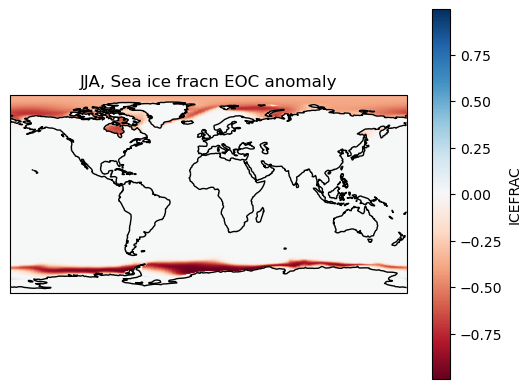

CPU times: user 3.64 s, sys: 119 ms, total: 3.76 s
Wall time: 4.9 s


In [50]:
%%time
ax = plt.axes(projection=cart.crs.PlateCarree())
sicefrac_jja_ano.mean({'month','member'}).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap='RdBu')
ax.coastlines(color="black")
plt.title('JJA, Sea ice fracn EOC anomaly')
plt.show()

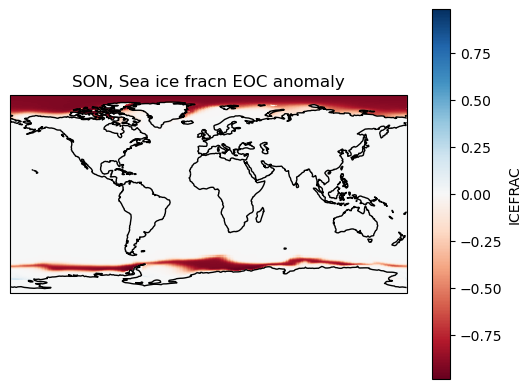

CPU times: user 3.72 s, sys: 123 ms, total: 3.85 s
Wall time: 5.18 s


In [51]:
%%time
ax = plt.axes(projection=cart.crs.PlateCarree())
sicefrac_son_ano.mean({'month','member'}).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap='RdBu')
ax.coastlines(color="black")
plt.title('SON, Sea ice fracn EOC anomaly')
plt.show()

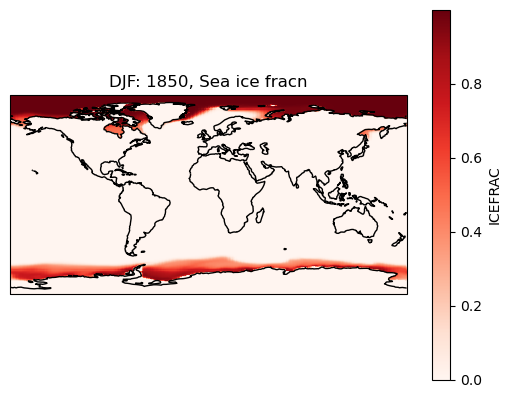

CPU times: user 2.95 s, sys: 75.3 ms, total: 3.02 s
Wall time: 4.8 s


In [48]:
%%time
ax = plt.axes(projection=cart.crs.PlateCarree())
sicefrac_djf.mean({'month','member'}).sel(year=1850).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap='Reds')
ax.coastlines(color="black")
plt.title('DJF: 1850, Sea ice fracn')
plt.show()

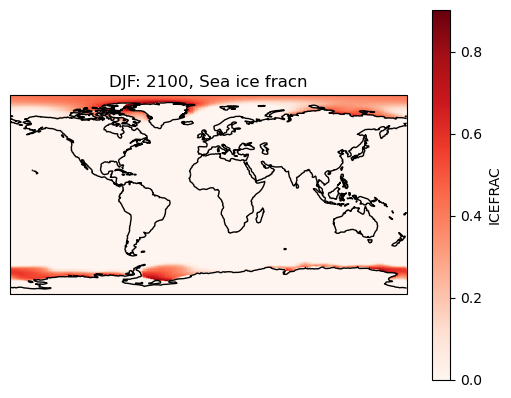

CPU times: user 3.81 s, sys: 126 ms, total: 3.94 s
Wall time: 5.77 s


In [49]:
%%time
ax = plt.axes(projection=cart.crs.PlateCarree())
sicefrac_djf.mean({'month','member'}).sel(year=2100).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap='Reds')
ax.coastlines(color="black")
plt.title('DJF: 2100, Sea ice fracn')
plt.show()

In [ ]:
##################################

In [ ]:
%%time 
snowfrac = xr.open_mfdataset(snowfrac_path+'*.nc',engine='netcdf4')
snowfrac

In [ ]:
landfrac.sel(time='18500201').plot()

In [ ]:
landfrac.sel(time='21000101').plot()

In [ ]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

In [ ]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw   = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))
         #.sel(lon=slice(left,right)).sel(lat=slice(bottom,top))
tghw   = ds_hist.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
#tgnw

In [ ]:
%%time
tgw_trim     = tgw.drop_isel({'time':-1}).sel(time=slice(ic_year0,ic_year1)) #Drop Jan 1, 2101 data
tghw_trim    = tghw.drop_isel({'time':-1}).sel(time=slice(pi_year0,pi_year1)) #Drop an extra copy of Jan 1, 2015 data
tgmw         = xr.concat([tghw_trim,tgw_trim],dim='time')
tgmw         = tgmw.chunk({'time':900,'lat':20,'lon':30,'member':100})   
tgmw

In [ ]:
%%time
########### Save the absolute errors ############
#DJF
qgmsc_djf_errpath   = cvals+'qgmsc_err' +'djf'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_djf_errpath  = cvals+'qgauss_err'+'djf'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_djf_errpath    = cvals+'qgmc_err' +'djf'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgeocm_djf_errpath  = cvals+'qgeocm_err'+'djf'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#MAM
qgmsc_mam_errpath   = cvals+'qgmsc_err' +'mam'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_mam_errpath  = cvals+'qgauss_err'+'mam'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_mam_errpath    = cvals+'qgmc_err' +'mam'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgeocm_mam_errpath  = cvals+'qgeocm_err'+'mam'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#JJA
qgmsc_jja_errpath   = cvals+'qgmsc_err' +'jja'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_jja_errpath  = cvals+'qgauss_err'+'jja'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_jja_errpath    = cvals+'qgmc_err' +'jja'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgeocm_jja_errpath  = cvals+'qgeocm_err'+'jja'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#SON
qgmsc_son_errpath   = cvals+'qgmsc_err' +'son'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_son_errpath  = cvals+'qgauss_err'+'son'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_son_errpath    = cvals+'qgmc_err' +'son'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgeocm_son_errpath  = cvals+'qgeocm_err'+'son'+'_'+ic_year0+'_'+ic_year1+'.zarr'

In [ ]:
##### Open ########
qgmsc_djf_err    = xr.open_zarr(qgmsc_djf_errpath)
qgauss_djf_err   = xr.open_zarr(qgauss_djf_errpath)
qgmc_djf_err     = xr.open_zarr(qgmc_djf_errpath)
qgeocm_djf_err   = xr.open_zarr(qgeocm_djf_errpath)
qgmsc_djf_err    = qgmsc_djf_err.TREFHTMX
qgauss_djf_err   = qgauss_djf_err.TREFHTMX
qgmc_djf_err     = qgmc_djf_err.TREFHTMX
qgeocm_djf_err   = qgeocm_djf_err.TREFHTMX

In [ ]:
##### Open ########
qgmsc_mam_err    = xr.open_zarr(qgmsc_mam_errpath)
qgauss_mam_err   = xr.open_zarr(qgauss_mam_errpath)
qgmc_mam_err     = xr.open_zarr(qgmc_mam_errpath)
qgeocm_mam_err   = xr.open_zarr(qgeocm_mam_errpath)
qgmsc_mam_err    = qgmsc_mam_err.TREFHTMX
qgauss_mam_err   = qgauss_mam_err.TREFHTMX
qgmc_mam_err     = qgmc_mam_err.TREFHTMX
qgeocm_mam_err   = qgeocm_mam_err.TREFHTMX

In [ ]:
##### Open ########
qgmsc_jja_err    = xr.open_zarr(qgmsc_jja_errpath)
qgauss_jja_err   = xr.open_zarr(qgauss_jja_errpath)
qgmc_jja_err     = xr.open_zarr(qgmc_jja_errpath)
qgeocm_jja_err   = xr.open_zarr(qgeocm_jja_errpath)
qgmsc_jja_err    = qgmsc_jja_err.TREFHTMX
qgauss_jja_err   = qgauss_jja_err.TREFHTMX
qgmc_jja_err     = qgmc_jja_err.TREFHTMX
qgeocm_jja_err   = qgeocm_jja_err.TREFHTMX

In [ ]:
##### Open ########
qgmsc_son_err    = xr.open_zarr(qgmsc_son_errpath)
qgauss_son_err   = xr.open_zarr(qgauss_son_errpath)
qgmc_son_err     = xr.open_zarr(qgmc_son_errpath)
qgeocm_son_err   = xr.open_zarr(qgeocm_son_errpath)
qgmsc_son_err    = qgmsc_son_err.TREFHTMX
qgauss_son_err   = qgauss_son_err.TREFHTMX
qgmc_son_err     = qgmc_son_err.TREFHTMX
qgeocm_son_err   = qgeocm_son_err.TREFHTMX

In [ ]:
####### Plot errors for all seasons #############

In [ ]:
######## New colorbar only for shift + stretch and gaussian ############
x = 5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

In [ ]:
%%time
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(13.5,10), 
                        subplot_kw={'projection': cart.crs.PlateCarree()}) 
                        #gridspec_kw = {'wspace':0.02, 'hspace':0.01,'top':0.4,'bottom':0.1})

# # Reduce the padding around each subplot
#plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Adding titles for the rows
fig.text(0.12, 0.86, 'DJF', va='center', rotation='vertical',fontsize=19)
fig.text(0.12, 0.67, 'MAM', va='center', rotation='vertical',fontsize=19)
fig.text(0.12, 0.48, 'JJA', va='center', rotation='vertical',fontsize=19)
fig.text(0.12, 0.28, 'SON', va='center', rotation='vertical',fontsize=19)

# Plotting qgmsc_err1
im1= qgmsc_djf_err.sel(quantile=0.9).mean('day').plot(ax=axs[0, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[0, 0].coastlines(color="black")
axs[0, 0].set_title('(pi + ss) - eoc',fontsize=19)
#
im2 = qgmsc_mam_err.sel(quantile=0.9).mean('day').plot(ax=axs[1, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[1, 0].coastlines(color="black")
axs[1, 0].set_title('')
#
im3 = qgmsc_jja_err.sel(quantile=0.9).mean('day').plot(ax=axs[2, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[2, 0].coastlines(color="black")
axs[2, 0].set_title('')
#
im4 = qgmsc_son_err.sel(quantile=0.9).mean('day').plot(ax=axs[3, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[3, 0].coastlines(color="black")
axs[3, 0].set_title('')

##### DJF #################
# # Plotting qgauss_err1
im5 = qgauss_djf_err.sel(quantile=0.9).mean('day').plot(ax=axs[0, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[0, 1].coastlines(color="black")
axs[0, 1].set_title('gauss - eoc',fontsize=19)

######## Plotting MAM #######################
# Plotting qgauss_err1
im6 = qgauss_mam_err.sel(quantile=0.9).mean('day').plot(ax=axs[1, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[1, 1].coastlines(color="black")
axs[1, 1].set_title('')

######## Plotting JJA #######################

# Plotting qgauss_err1
im7 = qgauss_jja_err.sel(quantile=0.9).mean('day').plot(ax=axs[2, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[2, 1].coastlines(color="black")
axs[2, 1].set_title('')
######## Plotting SON #######################

# Plotting qgauss_err1
im8 = qgauss_son_err.sel(quantile=0.9).mean('day').plot(ax=axs[3, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[3, 1].coastlines(color="black")
axs[3, 1].set_title('')

# Creating a mappable object for the colorbar
mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([])


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.05, right=0.95,
                    wspace=0.001, hspace=0.05)

# Adding colorbar
cbar = plt.colorbar(mappable, ax=axs.ravel().tolist(), shrink=1, orientation='vertical')
cbar.set_label('Errors (K)',fontsize=19)
#fig.tight_layout()
plt.show()

In [ ]:
%%time
qgmsc_err = xr.concat([qgmsc_djf_err,qgmsc_mam_err,qgmsc_jja_err,qgmsc_son_err],dim='day')
qgmc_err  = xr.concat([qgmc_djf_err,qgmc_mam_err,qgmc_jja_err,qgmc_son_err],dim='day')
#qgmsc_err

In [ ]:
%%time
qgauss_err = xr.concat([qgauss_djf_err,qgauss_mam_err,qgauss_jja_err,qgauss_son_err],dim='day')
qgeocm_err = xr.concat([qgeocm_djf_err,qgeocm_mam_err,qgeocm_jja_err,qgeocm_son_err],dim='day')
#qgauss_err

In [ ]:
# Take a zonal average (weighted mean over longitude)

In [ ]:
weights      = np.cos(np.deg2rad(qgmsc_err.lat))
weights.name = "weights"

In [ ]:
%%time
qgmsc_err_weighted     = qgmsc_err.weighted(weights)
qgauss_err_weighted    = qgauss_err.weighted(weights)

In [ ]:
qgmsc_err_zmean     = qgmsc_err_weighted.mean('lon')
qgauss_err_zmean    = qgauss_err_weighted.mean('lon')

In [ ]:
##### Get masked arrays for land and ocean #############

In [ ]:
%%time
landfrac        = landfrac.sel(time='21000101')
qgmsc_abserr    = (np.fabs(qgmsc_err) < 1.0)
qgauss_abserr   = (np.fabs(qgauss_err) < 1.0)
qgauss_abserr

In [ ]:
%%time
M                     = 192*288*365
qgmsc_err_fracn1      = qgmsc_abserr.sum({'day','lat','lon'})/M
qgauss_err_fracn1     = qgauss_abserr.sum({'day','lat','lon'})/M
#### Land #######
qgmsc_land_errfracn1  = qgmsc_abserr.where(landfrac==1).mean({'day','lat','lon'},skipna=True)
qgauss_land_errfracn1 = qgauss_abserr.where(landfrac==1).mean({'day','lat','lon'},skipna=True)
#### Ocean ######
qgmsc_ocean_errfracn1 = qgmsc_abserr.where(landfrac==0).mean({'day','lat','lon'},skipna=True)
qgauss_ocean_errfracn1= qgauss_abserr.where(landfrac==0).mean({'day','lat','lon'},skipna=True)

In [ ]:
#landfrac.values

In [ ]:
# %%time
M                      = 192*288*365
# qgmw_diff_fracn0.5     = (np.fabs(qgmw_diff) < 0.5).sum({'day','lat','lon'})/M
# qgmw_reldiff1_fracn0.5 = (np.fabs(qgmw_reldiff1) < 0.5).sum({'day','lat','lon'})/M
# qgmw_reldiff2_fracn0.5 = (np.fabs(qgmw_reldiff2) < 0.5).sum({'day','lat','lon'})/M

In [ ]:
# qgmsc_err_chk      = (np.fabs(qgmsc_err) < 1.0)
# qgmsc_land_err_chk = qgmsc_err_chk.where(landfrac==1).mean(['day','lat','lon'],skipna=True)
# qgmsc_land_err_chk.plot()

In [ ]:
# qgmsc_land_err_chk2 = (np.fabs(qgmsc_land_err) < 1.0)
# qgmsc_land_err_chk2.sum('day').sel(quantile=0.5).plot()

In [ ]:
quants = np.arange(0.0,1.01,0.01)

In [ ]:
%%time
########### Save the fracn of errors <1K  ############
qgmsc_errfracn1path           = cvals+'qgmsc_err<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_errfracn1path          = cvals+'qgauss_err<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#### Land #######
qgmsc_land_errfracn1path   = cvals+'qgmsc_err_land<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_land_errfracn1path  = cvals+'qgauss_err_land<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
##### Ocean #####
qgmsc_ocean_errfracn1path  = cvals+'qgmsc_err_ocean<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_ocean_errfracn1path = cvals+'qgauss_err_ocean<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
########################################
# qgmsc_land_errfracn1.to_dataset().to_zarr(qgmsc_land_errfracn1path,mode='w')
# qgauss_land_errfracn1.to_dataset().to_zarr(qgauss_land_errfracn1path,mode='w')
# #
# qgmsc_ocean_errfracn1.to_dataset().to_zarr(qgmsc_ocean_errfracn1path,mode='w')
# qgauss_ocean_errfracn1.to_dataset().to_zarr(qgauss_ocean_errfracn1path,mode='w')
# #
# qgmsc_err_fracn1.to_dataset().to_zarr(qgmsc_errfracn1path,mode='w')
# qgauss_err_fracn1.to_dataset().to_zarr(qgauss_errfracn1path,mode='w')

In [ ]:
########### Open and PLot ############
qgmsc_land_errfracn1  = xr.open_zarr(qgmsc_land_errfracn1path)
qgauss_land_errfracn1 = xr.open_zarr(qgauss_land_errfracn1path)
qgmsc_land_errfracn1  = qgmsc_land_errfracn1.TREFHTMX
qgauss_land_errfracn1 = qgauss_land_errfracn1.TREFHTMX
##
qgmsc_ocean_errfracn1 = xr.open_zarr(qgmsc_ocean_errfracn1path)
qgauss_ocean_errfracn1= xr.open_zarr(qgauss_ocean_errfracn1path)
qgmsc_ocean_errfracn1 = qgmsc_ocean_errfracn1.TREFHTMX
qgauss_ocean_errfracn1= qgauss_ocean_errfracn1.TREFHTMX
#
qgmsc_errfracn1       = xr.open_zarr(qgmsc_errfracn1path)
qgauss_errfracn1      = xr.open_zarr(qgauss_errfracn1path)
qgmsc_errfracn1       = qgmsc_errfracn1.TREFHTMX
qgauss_errfracn1      = qgauss_errfracn1.TREFHTMX

In [ ]:
%%time
quants = np.arange(0,1.01,0.01)
plt.plot(quants,qgmsc_land_errfracn1,label='actual - (pi + ss)', c='tab:blue')
plt.plot(quants,qgauss_land_errfracn1,label='actual - gauss',c='tab:orange')
#plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
plt.legend(loc='center right')
plt.title('CESM2: Fraction of (land) locations and days with errors<1 K')
plt.ylabel('Fractions')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.show()

In [ ]:
#qgmw_reldiff2_fracn0.values

In [ ]:
%%time
plt.plot(quants,qgmsc_ocean_errfracn1,label='actual - (pi + ss)', c='tab:blue')
plt.plot(quants,qgauss_ocean_errfracn1,label='actual - gauss',c='tab:orange')
#plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
plt.legend(loc='center right')
plt.title('Fraction of (ocean) locations and days with errors<1K')
plt.ylabel('Fractions')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.show()

In [ ]:
%%time
plt.plot(quants,qgmsc_errfracn1,label='(pi + ss) - eoc', c='tab:blue')
plt.plot(quants,qgauss_errfracn1,label='gauss - eoc',c='tab:orange')
#plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
plt.legend(loc='center right')
plt.title('CESM2: Fraction of locations and days with errors<1K')
plt.ylabel('Fractions')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.show()

In [ ]:
############# Plot 4 ################

In [ ]:
# %%time
# #Quantile q=0.1
# #Plot 4c
# levs     = np.arange(-4,4.4,0.4)
# ax       = plt.axes(projection=cart.crs.PlateCarree())
# qgmw_son_reldiff2.sel(quantile=0.9).mean('day')\
# .plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs,cmap=cmap_divergent)
# plt.plot(-87.629,41.94,marker='*')
# plt.plot(77.5,12.72,marker='*')
# ax.coastlines(color="black")
# #ax.gridlines()
# #plt.title('q=0.9,'+r'$\delta t_w - 0$')
# plt.title('q=0.9, actual - (pi + shift + stretch), SON mean')

In [ ]:
############## Plot 5 #########################

In [ ]:
############# Compute area-weighted mean square of the above errors #####################

In [ ]:
# g = global, l=land, o=ocean
qgmsc_grmse   = global_annual_rmse(qgmsc_err,'day')
qgauss_grmse  = global_annual_rmse(qgauss_err,'day')
qgmc_grmse    = global_annual_rmse(qgmc_err,'day')
qgeocm_grmse  = global_annual_rmse(qgeocm_err,'day')
qgmsc_lrmse   = global_annual_rmse(qgmsc_err.where(landfrac==1),'day')
qgauss_lrmse  = global_annual_rmse(qgauss_err.where(landfrac==1),'day')
qgmsc_ormse   = global_annual_rmse(qgmsc_err.where(landfrac==0),'day')
qgauss_ormse  = global_annual_rmse(qgauss_err.where(landfrac==0),'day')

In [ ]:
qgmsc_lrmse

In [ ]:
%%time
# qgmw_grmsepath   = cvals+'qgmw_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_grmsepath   = cvals+'qgmc_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_grmsepath  = cvals+'qgmsc_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_grmsepath = cvals+'qgauss_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgeocm_grmsepath = cvals+'qgeocm_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#
qgmsc_lrmsepath  = cvals+'qgmsc_land_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_lrmsepath = cvals+'qgauss_land_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#
qgmsc_ormsepath  = cvals+'qgmsc_ocean_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_ormsepath = cvals+'qgauss_ocean_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
##########################
# qgmw_grmse.to_dataset().to_zarr(qgmw_grmsepath,mode='w')
# qgmc_grmse.to_dataset().to_zarr(qgmc_grmsepath,mode='w')
# qgmsc_grmse.to_dataset().to_zarr(qgmsc_grmsepath,mode='w')
# qgauss_grmse.to_dataset().to_zarr(qgauss_grmsepath,mode='w')
# qgeocm_grmse.to_dataset().to_zarr(qgeocm_grmsepath,mode='w')
# #
# qgmsc_lrmse.to_dataset().to_zarr(qgmsc_lrmsepath,mode='w')
# qgauss_lrmse.to_dataset().to_zarr(qgauss_lrmsepath,mode='w')
# #
# qgmsc_ormse.to_dataset().to_zarr(qgmsc_ormsepath,mode='w')
# qgauss_ormse.to_dataset().to_zarr(qgauss_ormsepath,mode='w')

In [ ]:
%%time
# qgmw_grmse   = xr.open_zarr(qgmw_grmsepath)
qgmc_grmse   = xr.open_zarr(qgmc_grmsepath)
# qgmw_grmse   = qgmw_grmse.TREFHTMX
qgmc_grmse   = qgmc_grmse.TREFHTMX
qgmsc_grmse  = xr.open_zarr(qgmsc_grmsepath)
qgauss_grmse = xr.open_zarr(qgauss_grmsepath)
qgeocm_grmse = xr.open_zarr(qgeocm_grmsepath)
qgmsc_lrmse  = xr.open_zarr(qgmsc_lrmsepath)
qgauss_lrmse = xr.open_zarr(qgauss_lrmsepath)
qgmsc_ormse  = xr.open_zarr(qgmsc_ormsepath)
qgauss_ormse = xr.open_zarr(qgauss_ormsepath)
#
qgmsc_grmse  = qgmsc_grmse.TREFHTMX
qgauss_grmse = qgauss_grmse.TREFHTMX
qgeocm_grmse = qgeocm_grmse.TREFHTMX
#
qgmsc_lrmse  = qgmsc_lrmse.TREFHTMX
qgauss_lrmse = qgauss_lrmse.TREFHTMX
#
qgmsc_ormse  = qgmsc_ormse.TREFHTMX
qgauss_ormse = qgauss_ormse.TREFHTMX
#

In [ ]:
%%time
plt.plot(quants,qgmsc_grmse,label='(pi + ss) - eoc',color='tab:blue')
plt.plot(quants,qgmc_grmse,'--',label = '(pi + s) - eoc',color='tab:blue')
plt.plot(quants,qgauss_grmse,label='gauss - eoc',color='tab:orange')
plt.plot(quants,qgeocm_grmse,'--',label = 'mean-only gauss - eoc',color='tab:orange')
plt.legend(loc='upper left')
plt.title('CESM2: Global,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,3.0)
plt.show()

In [ ]:
%%time
plt.plot(quants,qgmsc_lrmse,label='(pi + ss) - eoc',color='tab:blue')
plt.plot(quants,qgauss_lrmse,label='gauss - eoc',color='tab:orange')
plt.legend(loc='center right')
plt.title('CESM2: Land,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Percentiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,3.0)
plt.show()

In [ ]:
%%time
plt.plot(quants,qgmsc_ormse,label='(pi + ss) - eoc',color='tab:blue')
plt.plot(quants,qgauss_ormse,label='gauss - eoc',color='tab:orange')
plt.legend(loc='center right')
plt.title('CESM2: Ocean,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Percentiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,3.0)
plt.show()

In [ ]:
#qgmsc_lrmse.values

In [ ]:
#qgauss_lrmse.values

In [ ]:
#qgmsc_ormse.values

In [ ]:
#qgauss_ormse.values

In [ ]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4.5),gridspec_kw = {'wspace':0.2, 'hspace':0.2})

qgmsc_lrmse.plot(ax=axs[0],label='(pi + ss) - eoc')
qgauss_lrmse.plot(ax=axs[0],label='gauss - eoc')
axs[0].set_title('Land')
axs[0].set_xlabel('Quantiles')
axs[0].set_ylabel('Tmax RMSE (K)')
axs[0].set_xlim(0.0,1.0)
axs[0].set_ylim(0.0,3.0)
axs[0].legend(loc='center right')
#
im = qgmsc_ormse.plot(ax=axs[1],label='(pi + ss) - eoc')
qgauss_ormse.plot(ax=axs[1],label='gauss - eoc')
axs[1].set_title('Ocean')
axs[1].set_xlabel('Quantiles')
axs[1].set_ylabel('')
axs[1].set_xlim(0.0,1.0)
axs[1].set_ylim(0.0,3.0)
axs[1].legend(loc='center right')
# plot.show()

In [ ]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10),gridspec_kw = {'wspace':0.2, 'hspace':0.2})

im1 = qgmsc_lrmse.plot(ax=axs[0,0],label='(pi + ss) - eoc')
qgauss_lrmse.plot(ax=axs[0,0],label='gauss - eoc')
axs[0,0].set_title('Land',fontsize=16)
axs[0,0].set_xlabel('')
axs[0,0].set_ylabel('Tmax RMSE (K)',fontsize=16)
axs[0,0].set_xlim(0.0,1.0)
axs[0,0].set_ylim(0.0,3.0)
axs[0,0].legend(loc='center right')
#
im2 = qgmsc_ormse.plot(ax=axs[0,1],label='(pi + ss) - eoc')
qgauss_ormse.plot(ax=axs[0,1],label='gauss - eoc')
axs[0,1].set_title('Ocean',fontsize=16)
axs[0,1].set_xlabel('')
axs[0,1].set_ylabel('')
axs[0,1].set_xlim(0.0,1.0)
axs[0,1].set_ylim(0.0,3.0)
axs[0,1].legend(loc='center right')
#
im3 = qgmsc_land_errfracn1.plot(ax=axs[1,0],label='(pi + ss) - eoc')
qgauss_land_errfracn1.plot(ax=axs[1,0],label='gauss - eoc')
axs[1,0].set_title('')
axs[1,0].set_xlabel('Quantiles',fontsize=16)
axs[1,0].set_ylabel('Fractions',fontsize=16)
axs[1,0].set_xlim(0.0,1.0)
axs[1,0].set_ylim(0.0,1.0)
axs[1,0].legend(loc='center right')
#
im4 = qgmsc_ocean_errfracn1.plot(ax=axs[1,1],label='(pi + ss) - eoc')
qgauss_ocean_errfracn1.plot(ax=axs[1,1],label='gauss - eoc')
axs[1,1].set_title('')
axs[1,1].set_xlabel('Quantiles',fontsize=16)
axs[1,1].set_ylabel('')
axs[1,1].set_xlim(0.0,1.0)
axs[1,1].set_ylim(0.0,1.0)
axs[1,1].legend(loc='center right')
# plot.show()

In [ ]:
%%time
error_redn = qgmsc_grmse.integrate('quantile')/qgmc_grmse.integrate('quantile')
error_redn.values

In [ ]:
########## Check CLT ###########

In [ ]:
%%time
tgmw_d  = to_daily(tgmw)
tgmw_d0 = tgmw_d.sel(year=slice(1850,1879))
tgmw_d1 = tgmw_d.sel(year=slice(ic_year0,ic_year1))
tgmw_d1 = tgmw_d1.chunk({'day':30})
tgmw_d1

In [ ]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
quants             = np.arange(0,1.01,0.01)
N_mem              = 100
window_len         = 30
#r = roll, ndrop = drop NANs
tgmw_eocroll       = stack_roll(tgmw_d1,N_mem*window_len,N_mem)
tgmw_piroll        = stack_roll(tgmw_d0,N_mem*window_len,N_mem)
#########
tgmw_eocroll0      = tgmw_eocroll.sel(ym=[15])
tgmw_piroll0       = tgmw_piroll.sel(ym=[15])
tgmw_piroll0

In [ ]:
tgmw_eocmroll = tgmw_eocroll0.mean('index')
tgmw_eocsroll = tgmw_eocroll0.std('index')
qgmw_eocroll  = tgmw_eocroll0.quantile(quants,dim='index',skipna=False)
######################

In [ ]:
# Generate normal distributions using means and standard deviations
index = np.arange(3000) 

gaussians_eoc = xr.apply_ufunc(
    np.random.normal,
    tgmw_eocmroll,
    tgmw_eocsroll,
    input_core_dims=[[], []],
    output_core_dims=[['index']],
    vectorize=True,
    output_dtypes=[float],
    kwargs={'size': 3000},
     output_sizes={'index': 3000},
    dask='parallelized'
)

In [ ]:
qgauss_eoc = gaussians_eoc.quantile(quants,dim='index',skipna=False)

In [ ]:
qgmw_gauss_diff   = qgauss_eoc - qgmw_eocroll

In [ ]:
### ###Save ######
qgmw_gauss_diffpath      = cvals+'qgmw_gauss_diff'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#qgmw_gauss_diff.to_dataset().to_zarr(qgmw_gauss_diffpath,mode='w')

In [ ]:
# qgmw_gauss_diff   = xr.open_zarr(qgmw_gauss_diff)
# qgmw_gauss_diff   = qgmw_gauss_diff.TREFHTMX

In [ ]:
qgmw_gesq                   = qgmw_gauss_diff**2
qgmw_gauss_serror_weighted  = qgmw_gesq.weighted(weights)
qgmw_gauss_serror_gmean     = qgmw_gauss_serror_weighted.mean({'lat','lon'})
################################################

In [ ]:
qgmw_gauss_gmse            = qgmw_gauss_serror_gmean.mean('day')
qgmw_gauss_grmse           = np.sqrt(qgmw_gauss_gmse)
qgmw_gauss_grmse 

In [ ]:
%%time
qgmw_gauss_grmsepath = cvals+'qgmw_gauss_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
##########################
#qgmw_gauss_grmse.to_dataset().to_zarr(qgmw_gauss_grmsepath,mode='w')

In [ ]:
qgmw_gauss_grmse = xr.open_zarr(qgmw_gauss_grmsepath)
qgmw_gauss_grmse = qgmw_gauss_grmse.TREFHTMX

In [ ]:
%%time
plt.plot(quants,qgmw_grmse,label='eoc - pi',color='tab:blue')
plt.plot(quants,qgmw_gauss_grmse,label='eoc - gaussian',color='red')
plt.plot(quants,qgmc_grmse,label='eoc - (pi + shift)',color='tab:orange')
plt.plot(quants,qgmsc_grmse,label='eoc - (pi + shift + stretch)',color='tab:green')
plt.legend(loc='center right')
plt.title('CESM2: Global,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Percentiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,5.0)
plt.show()